In [1]:
import os
import sys
import numpy as np
from matplotlib import pyplot as plt
import itertools

current_dir = os.getcwd()
main_dir = os.path.dirname(current_dir)
sys.path.append(main_dir)

from echonet_a4c_example import Example, val_examples
import echonet_a4c_example

In [2]:
def mean_iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    if union == 0:
        return 1.0 if intersection == 0 else 0.0
    iou = intersection / union
    return iou
    
    
def dice_coefficient(mask1, mask2):
    intersection = np.logical_and(mask1, mask2).sum()
    sum_masks = mask1.sum() + mask2.sum()
    if sum_masks == 0:
        return 1.0 if intersection == 0 else 0.0
    dice = 2 * intersection / sum_masks
    return dice

In [3]:
def plot_labels(labels, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    colors = ["C" + str(i) for i in range(8)]
    ax.set_xlim(0, 112)
    ax.set_ylim(0, 112)
    for i, labeler_segments in enumerate(labels):
        for x1, y1, x2, y2 in labeler_segments:
            ax.plot([x1, x2], [112-y1, 112-y2], color=colors[i], linewidth=3)
    if ax is None:
        plt.show()

In [4]:
def calculate_inter_annotator_errors(studied_examples, studied_state, k, l):
    """
    Compare different combinations of segmentation masks from multiple annotations.

    For each example in `studied_examples`, the function retrieves the segmentation labels
    corresponding to the specified cardiac state.
    It then generates all possible combinations of `k` annotations for the first group and `l` annotations
    for the second group from the remaining annotations. The mean masks of these groups are computed,
    binarized, and compared using the Dice coefficient to assess similarity.

    Parameters:
        studied_state (str): The cardiac state to study ('diastol' for diastole or any other value for systole).
        k (int): The number of annotations to select for the first group.
        l (int): The number of annotations to select for the second group.
        studied_examples (list, optional): A list of examples to analyze. If None, a default list
            based on `studied_state` is used.

    Returns:
        tuple:
            - diff_scores (numpy.ndarray): Array of Dice coefficients between the combined masks of the two groups.
            - mask_areas (numpy.ndarray): Array of average mask areas of the two groups.
            - total_inversions (numpy.ndarray): Array of total inversions (sum of absolute differences) between the combined masks.
            - examples (list): List of example names corresponding to each comparison.

    """
        
    diff_scores = []
    mask_areas = []
    total_inversions = []
    examples = []

    for x in studied_examples:
        some_example = Example(x)
        if studied_state == "diastol":
            labels = some_example.get_diastol_labels()
        else:
            labels = some_example.get_systol_labels()
        
        masks = [echonet_a4c_example.mask_from_trace(t) for t in labels]
        num_masks = len(masks)
        
        if num_masks < k + l:
            continue  # Skip if there are not enough masks to compare

        all_indices = set(range(num_masks))
        
        for k_indices in itertools.combinations(all_indices, k):
            remaining_indices = all_indices - set(k_indices)
            for l_indices in itertools.combinations(remaining_indices, l):
                masks_k = [masks[i] for i in k_indices]
                masks_l = [masks[i] for i in l_indices]
                
                combined_mask_k = np.mean(masks_k, axis=0)
                combined_mask_l = np.mean(masks_l, axis=0)
                combined_mask_k = (combined_mask_k>=0.5).astype("int")
                combined_mask_l = (combined_mask_l>=0.5).astype("int")
                
                diff_score = dice_coefficient(combined_mask_k, combined_mask_l)
                mask_area = (combined_mask_k.sum() + combined_mask_l.sum()) / 2
                total_inversion = sum(sum(np.abs(combined_mask_k - combined_mask_l)))
                
                diff_scores.append(diff_score)
                mask_areas.append(mask_area)
                total_inversions.append(total_inversion)
                examples.append(some_example.example_name)
    
    return np.array(diff_scores), np.array(mask_areas), np.array(total_inversions), examples

In [5]:


studied_state = "diastol"
diff_scores, _, _, _ = calculate_inter_annotator_errors(studied_examples = val_examples,
                                                        studied_state = "diastol",
                                                        k = 1,
                                                        l = 2)
np.mean(diff_scores)

0.8732544036185645

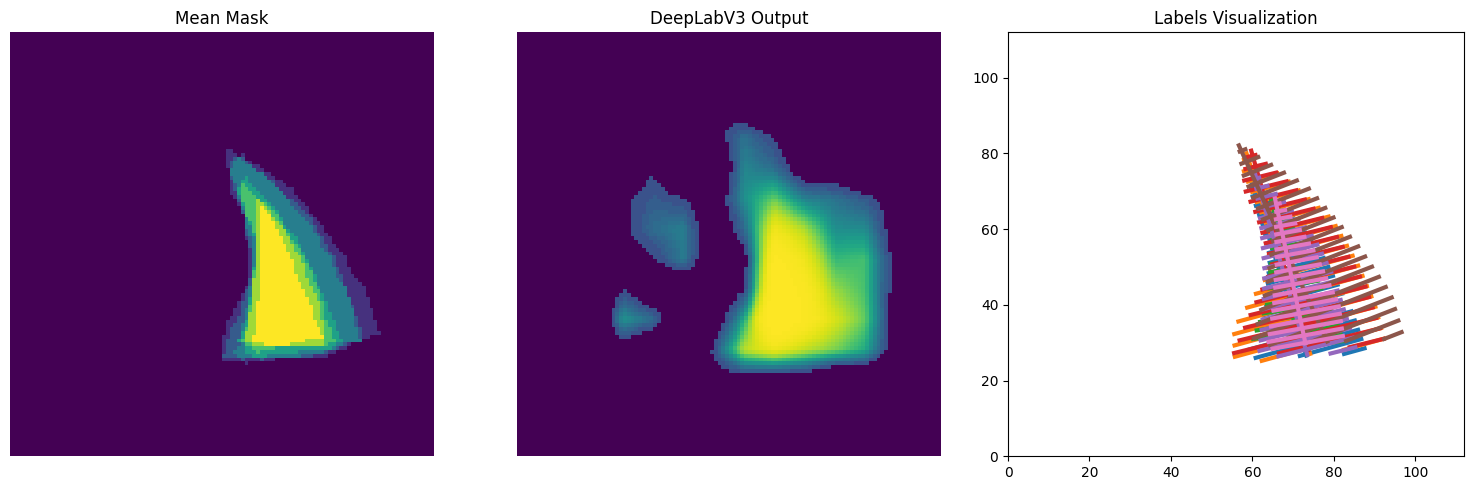

In [6]:


example_id = "0X35A5E9C9075E56EE"
labels = Example(example_id).get_systol_labels()
masks = [echonet_a4c_example.mask_from_trace(l) for l in labels]
meanmask = np.mean(masks, axis=0)

deeplab_output = Example(example_id).get_outputs(xp_name="echonet_deeplabV3")
d, s = Example(example_id).get_traced_frames()

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(meanmask)
axes[0].set_title('Mean Mask')
axes[0].axis('off')

axes[1].imshow(deeplab_output[s, :, :]**0.25)
axes[1].set_title('DeepLabV3 Output')
axes[1].axis('off')

plot_labels(labels, ax=axes[2])
axes[2].set_title('Labels Visualization')

plt.tight_layout()
plt.show()

In [8]:
some_example = "0X413DF958F18C23EF"

def reorder_points(x1, y1, x2, y2, account_for_vertical = True):
    x1, y1 = np.array(x1), np.array(y1)
    x2, y2 = np.array(x2), np.array(y2)
    
    vertical_segment_x1 = np.array([x1[0]])
    vertical_segment_y1 = np.array([y1[0]])
    vertical_segment_x2 = np.array([x2[0]])
    vertical_segment_y2 = np.array([y2[0]])
    if vertical_segment_y1 > vertical_segment_y2:
        (vertical_segment_x1,
        vertical_segment_y1,
        vertical_segment_x2,
        vertical_segment_y2) = (vertical_segment_x2,
                               vertical_segment_y2,
                               vertical_segment_x1,
                                vertical_segment_y1)
    
    x1_rest = x1[1:]
    y1_rest = y1[1:]
    x2_rest = x2[1:]
    y2_rest = y2[1:]
    
    points1_rest = np.vstack((x1_rest, y1_rest)).T
    points2_rest = np.vstack((x2_rest, y2_rest)).T
    
    combined_points_rest = np.vstack((points1_rest, points2_rest[::-1]))
    
    if account_for_vertical:
        middle_index = len(combined_points_rest) // 2
        combined_points = np.vstack((
            [vertical_segment_x1[0], vertical_segment_y1[0]],
            combined_points_rest[:middle_index],
            [vertical_segment_x2[0], vertical_segment_y2[0]],
            combined_points_rest[middle_index:]
        ))
    else: 
        combined_points = combined_points_rest
    
    return combined_points[:, 0], combined_points[:, 1]

In [9]:
def plot_image_with_contour(image, contour_points):
    fig, ax = plt.subplots()
    ax.imshow(image, cmap='gray')
    contour_points = np.vstack([contour_points, contour_points[0]])
    x_points, y_points = contour_points[:, 0], contour_points[:, 1]
    ax.plot(x_points, y_points, color='red', linewidth=4)    
    plt.axis("off")
    plt.show()

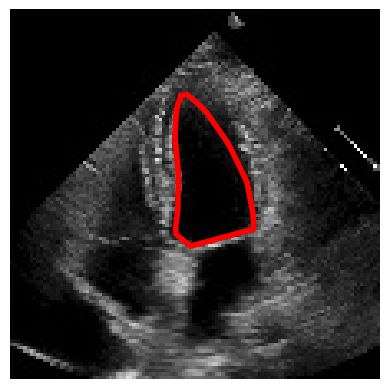

In [10]:


label_n = 0
phase = "systol"
if phase == "systol":
    points = Example(some_example).get_systol_labels()[label_n]
elif phase == "diastol":
    points = Example(some_example).get_diastol_labels()[label_n]
else:
    raise Exception

ordered_points = reorder_points(points[:,0],
                        points[:,1],
                        points[:,2],
                        points[:,3],
                        account_for_vertical=False)

if phase == "diastol":
    label_index = Example(some_example).get_traced_frames()[0]
else:
    label_index = Example(some_example).get_traced_frames()[1]
video = Example(some_example).get_video()
image = video[label_index,:,:,0]
contour_points = np.stack(ordered_points).transpose(1,0)
plot_image_with_contour(image, contour_points)